In [2]:
import pandas as pd

# Load datasets
cities_df = pd.read_csv('./cities_test.csv')
packages_df = pd.read_csv('./packages_test.csv')



In [2]:
!pip install gurobipy
from gurobipy import Model, GRB


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\steve\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
from gurobipy import *

In [4]:
import math

def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Create a distance matrix
distances = {}
for i, row_i in cities_df.iterrows():
    for j, row_j in cities_df.iterrows():
        dist = euclidean_distance(row_i['lat'], row_i['lon'], row_j['lat'], row_j['lon'])
        distances[(row_i['id'], row_j['id'])] = dist

distances


{(0, 0): 0.0,
 (0, 1): 1.0,
 (0, 2): 1.0,
 (1, 0): 1.0,
 (1, 1): 0.0,
 (1, 2): 1.4142135623730951,
 (2, 0): 1.0,
 (2, 1): 1.4142135623730951,
 (2, 2): 0.0}

In [5]:
# Create a distance matrix
packages = {}
for i, row_i in packages_df.iterrows():
    packages[(row_i['origin'], row_i['destination'])] = row_i['packages']

packages[(0, 0)] = 0
packages[(1, 1)] = 0
packages[(2, 2)] = 0
packages

{(0, 1): 50,
 (0, 2): 100,
 (1, 0): 10,
 (1, 2): 60,
 (2, 0): 200,
 (2, 1): 10,
 (0, 0): 0,
 (1, 1): 0,
 (2, 2): 0}

In [26]:
cities_df

,id,lat,lon
0,0,0,0
1,1,1,0
2,2,0,1


In [7]:
# Initialize model
model = Model("FreshFarm")

N = 3

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w")  # Introduced for Y[i, k] * Y[k, j]
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)

# Objective function with alpha = 0.75
alpha = 0.75
K = 2
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = sum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N))

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = sum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N))

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = sum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(sum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(sum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(sum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):

            # Wikj = Yik * Ykj
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] - 1)
        for m in range(N):
            for n in range(N):

                # Vimnj = Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] <= 1 - X[i])
                model.addConstr(V[i, m, n, j] <= 1 - X[j])
                # model.addConstr(V[i, m, n, j] <= X[m])
                # model.addConstr(V[i, m, n, j] <= X[n])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] + 1 - X[i] + 1 - X[j] - 4)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 625 rows, 129 columns and 1569 nonzeros


Model fingerprint: 0x42887f31
Model has 30 quadratic objective terms
Variable types: 0 continuous, 129 integer (129 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+01, 5e+02]
  QObjective range [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 453.8477631
Presolve removed 606 rows and 120 columns
Presolve time: 0.01s
Presolved: 28 rows, 18 columns, 75 nonzeros
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: objective 5.962311e+01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   59.62311    0    8  453.84776   59.62311  86.9%     -    0s
*    0     0               0     407.5000000  407.50000  0.00%     -    0s

Explored 1 nodes (14 simplex iterations) in 0.07 seconds (0.00 work units)
Thread co

In [8]:
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Optimal Solution Found
X[0] = 1.0
X[1] = 0.0
X[2] = 1.0
Y[0,0] = 0.0
Y[0,1] = 1.0
Y[0,2] = 1.0
Y[1,0] = 1.0
Y[1,1] = 0.0
Y[1,2] = 0.0
Y[2,0] = 1.0
Y[2,1] = 0.0
Y[2,2] = 0.0
Objective Value: 407.5


In [9]:
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1
cities

array([[0, 0],
       [1, 0],
       [0, 1]], dtype=int64)

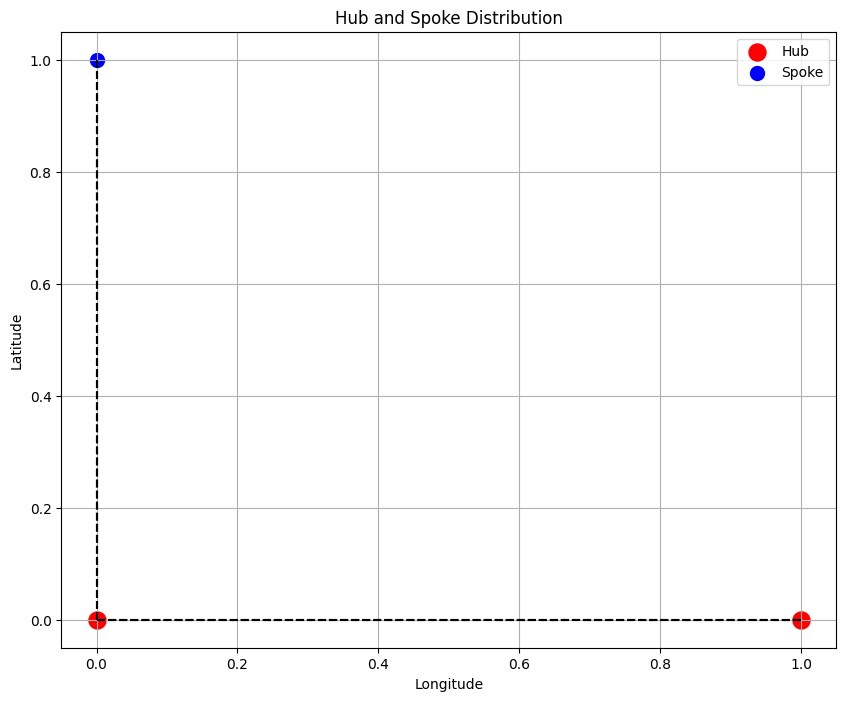

In [10]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# cities_df

In [14]:
# packages_df

In [5]:
# Load datasets
cities_df = pd.read_csv('./cities_small.csv')
packages_df = pd.read_csv('./packages_small.csv')

# Create a distance matrix
distances = {}
for i, row_i in cities_df.iterrows():
    for j, row_j in cities_df.iterrows():
        dist = euclidean_distance(row_i['lat'], row_i['lon'], row_j['lat'], row_j['lon'])
        distances[(int(row_i['id']), int(row_j['id']))] = dist

# Create a distance matrix
packages = {}
for i, row_i in packages_df.iterrows():
    packages[(row_i['origin'], row_i['destination'])] = row_i['packages']

for i in range(len(cities_df)):
    for j in range(len(cities_df)):
        if (i, j) not in packages:
            packages[(i, j)] = 0

print(distances)
print(packages)
print(len(distances))
print(len(packages))

{(0, 0): 0.0, (0, 1): 7.385265389230029, (0, 2): 38.15591593897656, (0, 3): 17.84376868899152, (0, 4): 5.408813028490058, (0, 5): 25.773889892811205, (0, 6): 41.49611653074913, (0, 7): 48.60553382145602, (0, 8): 39.29147706731318, (0, 9): 42.082014644191126, (0, 10): 34.74170158291984, (0, 11): 10.870017183439154, (0, 12): 28.091268550605463, (0, 13): 48.30461965636616, (0, 14): 30.044770767831277, (0, 15): 51.58763290393545, (0, 16): 11.176730921164692, (1, 0): 7.385265389230029, (1, 1): 0.0, (1, 2): 30.821370630396732, (1, 3): 11.140535810559616, (1, 4): 3.8947956806280275, (1, 5): 18.392032084910486, (1, 6): 34.214148100004024, (1, 7): 41.54601148997632, (1, 8): 32.38476390072753, (1, 9): 34.69721975018226, (1, 10): 27.874962861114362, (1, 11): 5.678534987172922, (1, 12): 20.7273715847404, (1, 13): 41.242281307611485, (1, 14): 23.63088834930368, (1, 15): 44.590700193329695, (1, 16): 4.106552016136462, (2, 0): 38.15591593897656, (2, 1): 30.821370630396732, (2, 2): 0.0, (2, 3): 21.180

In [6]:
cities_df

,id,lat,lon
0,0,37.618806,-122.375417
1,1,36.080044,-115.152235
2,2,33.636700,-84.427864
3,3,39.861667,-104.673167
4,4,33.942496,-118.408049
5,5,32.897233,-97.037695
6,6,35.213750,-80.949056
7,7,40.777250,-73.872611
8,8,42.212444,-83.353389
9,9,28.429389,-81.309000


In [7]:
packages_df

,origin,destination,packages
0,2,15,2878
1,2,6,3745
2,2,3,2973
3,2,5,4868
4,2,8,2796
...,...,...,...
258,11,9,358
259,11,14,1204
260,11,10,1441
261,11,16,3813


In [6]:
# Initialize model
model = Model("FreshFarm")

N = len(cities_df)

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w") # Introduced for Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj)
U = model.addVars(N, N, N, vtype=GRB.BINARY, name="u") # Introduced for Xi * Xk * Xj
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)

# Objective function with alpha = 0.75
alpha = 0.75
K = 2
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = quicksum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N) if i != j)

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = quicksum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j)

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = quicksum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(quicksum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(quicksum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(quicksum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):
            # Uikj = Xi * Xk * Xj
            model.addConstr(U[i, k, j] <= X[i])
            model.addConstr(U[i, k, j] <= X[k])
            model.addConstr(U[i, k, j] <= X[j])
            model.addConstr(U[i, k, j] >= X[i] + X[k] + X[j] - 2)

            # Wikj = Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj) = Y[i, k] * Y[k, j] * (1 - U[i, k, j])
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] <= 1 - U[i, k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] + (1 - U[i, k, j]) - 2)

        for m in range(N):
            for n in range(N):

                # Vimnj = Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] <= 1 - X[i])
                model.addConstr(V[i, m, n, j] <= 1 - X[j])
                # model.addConstr(V[i, m, n, j] <= X[m])
                # model.addConstr(V[i, m, n, j] <= X[n])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] + 1 - X[i] + 1 - X[j] - 4)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-25


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 542182 rows, 93942 columns and 1432794 nonzeros
Model fingerprint: 0x676ea53a
Model has 8153 quadratic objective terms
Variable types: 0 continuous, 93942 integer (93942 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 7e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 91368 rows and 14506 columns (presolve time = 5s) ...
Presolve removed 91368 rows and 14506 columns (presolve time = 10s) ...
Presolve removed 91368 rows and 14506 columns (presolve time = 15s) ...
Presolve removed 91368 rows and 14506 columns (presolve time = 20s) ...
Presolve removed 91370 rows and 14506 columns (presolve time = 25s) ...
Presolve removed 91370 rows

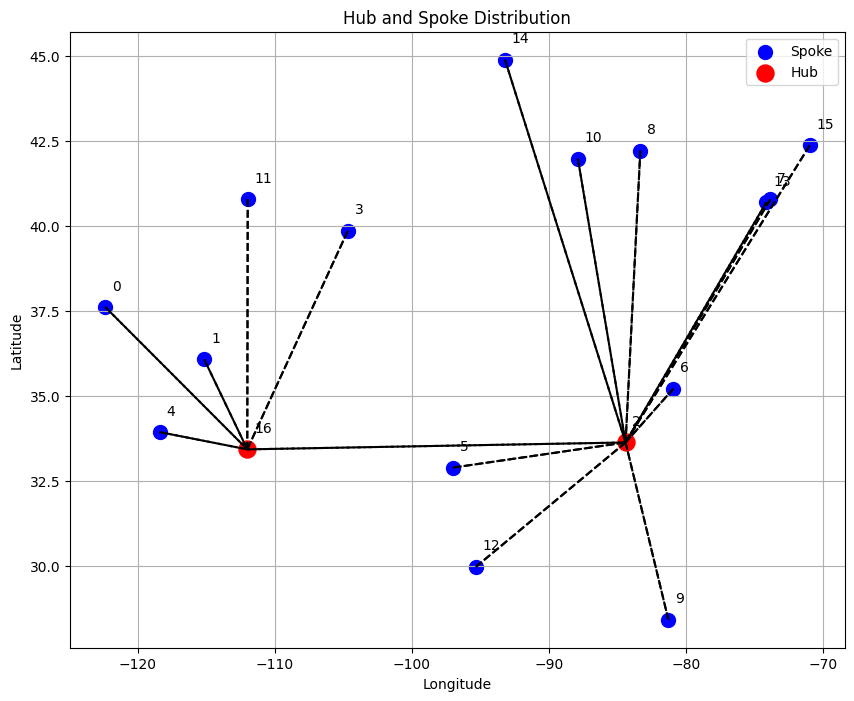

In [20]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

for i, row in cities_df.iterrows():
        plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Initialize model
model = Model("FreshFarm")

N = len(cities_df)

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w")  # Introduced for Y[i, k] * Y[k, j]
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)

# Objective function with alpha = 0.75
alpha = 0.75
K = 4
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = sum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N) if i != j)

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = sum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j)

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = sum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(sum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(sum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(sum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):

            # Wikj = Yik * Ykj * (1 - Xi * Xk * Xj), ensuring no h-h-h
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] - 1)
        for m in range(N):
            for n in range(N):

                # Vimnj = Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] <= 1 - X[i])
                model.addConstr(V[i, m, n, j] <= 1 - X[j])
                # model.addConstr(V[i, m, n, j] <= X[m])
                # model.addConstr(V[i, m, n, j] <= X[n])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] + 1 - X[i] + 1 - X[j] - 4)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 517617 rows, 89029 columns and 1369775 nonzeros
Model fingerprint: 0x510de29b
Model has 8153 quadratic objective terms
Variable types: 0 continuous, 89029 integer (89029 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 7e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 89939 rows and 14497 columns (presolve time = 5s) ...
Presolve removed 89939 rows and 14497 columns (presolve time = 10s) ...
Presolve removed 89939 rows and 14497 columns (presolve time = 15s) ...
Presolve removed 89939 rows and 14497 columns (presolve time = 20s) ...
Presolve removed 89948 rows and 14500 columns (presolve time = 25s) ...
Presolve removed 416773 row

In [22]:
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Optimal Solution Found
X[0] = 0.0
X[1] = 1.0
X[2] = 0.0
X[3] = 0.0
X[4] = 0.0
X[5] = 1.0
X[6] = 1.0
X[7] = 0.0
X[8] = 0.0
X[9] = 0.0
X[10] = 0.0
X[11] = 0.0
X[12] = 0.0
X[13] = 0.0
X[14] = 1.0
X[15] = 0.0
X[16] = 0.0
Y[0,0] = 0.0
Y[0,1] = 1.0
Y[0,2] = 0.0
Y[0,3] = 0.0
Y[0,4] = 0.0
Y[0,5] = 0.0
Y[0,6] = 0.0
Y[0,7] = 0.0
Y[0,8] = 0.0
Y[0,9] = 0.0
Y[0,10] = 0.0
Y[0,11] = 0.0
Y[0,12] = 0.0
Y[0,13] = 0.0
Y[0,14] = 0.0
Y[0,15] = 0.0
Y[0,16] = 0.0
Y[1,0] = 1.0
Y[1,1] = 0.0
Y[1,2] = 0.0
Y[1,3] = 0.0
Y[1,4] = 1.0
Y[1,5] = 1.0
Y[1,6] = 1.0
Y[1,7] = 0.0
Y[1,8] = 0.0
Y[1,9] = 0.0
Y[1,10] = 0.0
Y[1,11] = 1.0
Y[1,12] = 0.0
Y[1,13] = 0.0
Y[1,14] = 1.0
Y[1,15] = 0.0
Y[1,16] = 1.0
Y[2,0] = 0.0
Y[2,1] = 0.0
Y[2,2] = 0.0
Y[2,3] = 0.0
Y[2,4] = 0.0
Y[2,5] = 0.0
Y[2,6] = 1.0
Y[2,7] = 0.0
Y[2,8] = 0.0
Y[2,9] = 0.0
Y[2,10] = 0.0
Y[2,11] = 0.0
Y[2,12] = 0.0
Y[2,13] = 0.0
Y[2,14] = 0.0
Y[2,15] = 0.0
Y[2,16] = 0.0
Y[3,0] = 0.0
Y[3,1] = 0.0
Y[3,2] = 0.0
Y[3,3] = 0.0
Y[3,4] = 0.0
Y[3,5] = 1.0
Y[3,6] = 0.0
Y[3,7] =

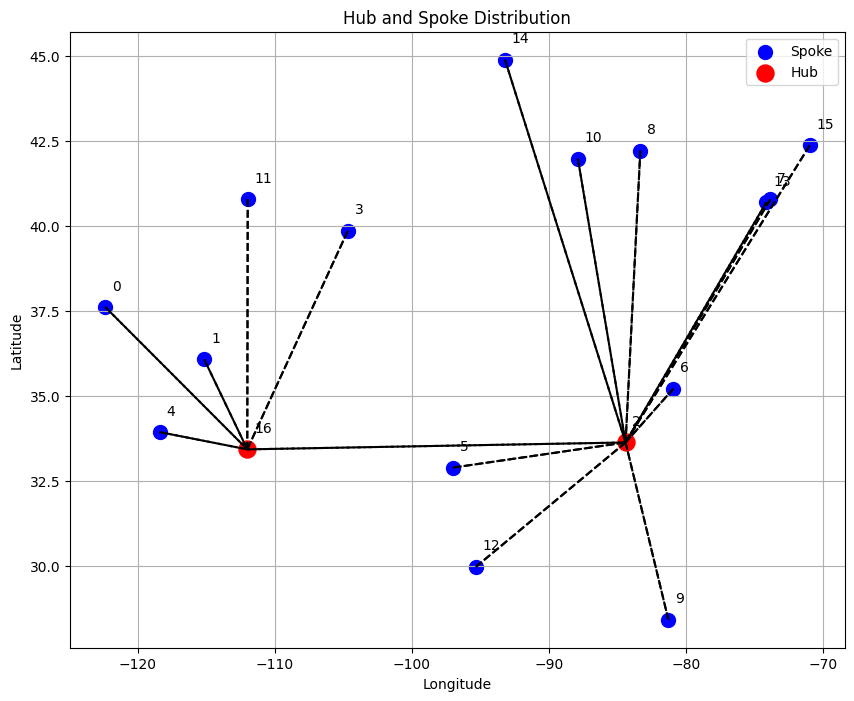

In [7]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

for i, row in cities_df.iterrows():
        plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# N = 3
# F = {(0,0):0, (0,1):0, (0,2):1, (1,0):0, (1,1):0, (1,2):3,(2,0):1, (2,1):0, (2,2):0 } 
# D = {(0,0):0, (0,1):1, (0,2):5, (1,0):1, (1,1):0, (1,2):2,(2,0):5, (2,1):2, (2,2):0 }

# Initialize model
model = Model("FreshFarm")

N = 3

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w")  # Introduced for Y[i, k] * Y[k, j]
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j]

# Objective function with alpha = 0.75
alpha = 0.75
K = 2
d = {(0,0):0, (0,1):1, (0,2):5, (1,0):1, (1,1):0, (1,2):2,(2,0):5, (2,1):2, (2,2):0 }
f = {(0,0):0, (0,1):0, (0,2):1, (1,0):0, (1,1):0, (1,2):3,(2,0):1, (2,1):0, (2,2):0 } 
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = sum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N))

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = sum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)]) 
                    for i in range(N) for j in range(N) for k in range(N))

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = sum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(sum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(sum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(sum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):

            # Wikj = Yik * Ykj
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] - 1)
        for m in range(N):
            for n in range(N):

                # Vimnj = Yim * Ymn * Ynj
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] - 2)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 463 rows, 129 columns and 1110 nonzeros
Model fingerprint: 0x4c525f00
Model has 15 quadratic objective terms
Variable types: 0 continuous, 129 integer (129 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e+00, 2e+01]
  QObjective range [5e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 27.2500000
Presolve removed 447 rows and 121 columns
Presolve time: 0.01s
Presolved: 22 rows, 14 columns, 59 nonzeros
Variable types: 0 continuous, 14 integer (14 binary)
Found heuristic solution: objective 21.7500000

Root relaxation: objective 2.250000e+00, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds  

In [10]:
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Optimal Solution Found
X[0] = 0.0
X[1] = 1.0
X[2] = 1.0
Y[0,0] = 0.0
Y[0,1] = 1.0
Y[0,2] = 0.0
Y[1,0] = 1.0
Y[1,1] = 0.0
Y[1,2] = 1.0
Y[2,0] = 0.0
Y[2,1] = 1.0
Y[2,2] = 0.0
Objective Value: 9.5


In [6]:
# Load datasets
cities_df = pd.read_csv('./cities_small.csv')
packages_df = pd.read_csv('./packages_small.csv')

# Load datasets
cities_df = pd.read_csv('./cities_small.csv')
packages_df = pd.read_csv('./packages_small.csv')

# Create a distance matrix
distances = {}
for i, row_i in cities_df.iterrows():
    for j, row_j in cities_df.iterrows():
        dist = euclidean_distance(row_i['lat'], row_i['lon'], row_j['lat'], row_j['lon'])
        distances[(int(row_i['id']), int(row_j['id']))] = dist

# Create a distance matrix
packages = {}
for i, row_i in packages_df.iterrows():
    packages[(row_i['origin'], row_i['destination'])] = row_i['packages']

for i in range(len(cities_df)):
    for j in range(len(cities_df)):
        if (i, j) not in packages:
            packages[(i, j)] = 0

# print(distances)
# print(packages)
# print(len(distances))
# print(len(packages))

# Initialize model
model = Model("FreshFarm")

N = len(cities_df)

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w")  # Introduced for Y[i, k] * Y[k, j]
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j]

# Objective function with alpha = 0.75
alpha = 0.75
K = 1
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = sum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N))

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = sum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N))

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = sum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(sum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(sum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(sum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):

            # Wikj = Yik * Ykj
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] - 1)
        for m in range(N):
            for n in range(N):

                # Vimnj = Yim * Ymn * Ynj
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] - 2)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-25
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350575 rows, 89029 columns and 873562 nonzeros
Model fingerprint: 0xca8eb761
Model has 8679 quadratic objective terms
Variable types: 0 continuous, 89029 integer (89029 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 7e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 58332 rows and 14505 columns (presolve time = 5s) ...
Presolve removed 58916 rows and 14599 columns (presolve time = 10s) ...
Presolve removed 287575 rows and 49453 columns (presolve time = 15s) ...
Presolve removed 320704 rows and 59176 columns
Presolve time: 16.42s
Presolved: 

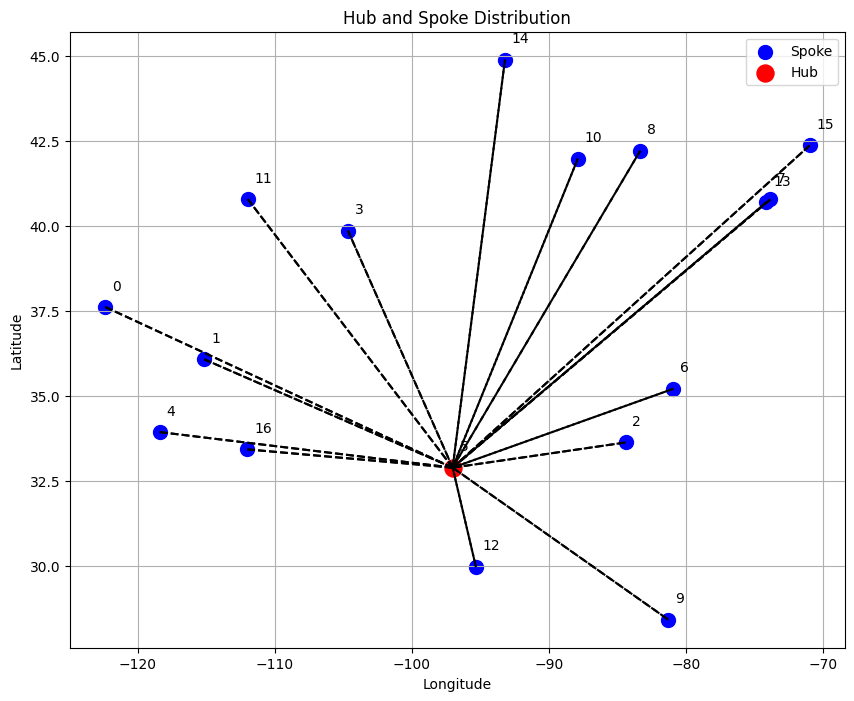

In [7]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

for i, row in cities_df.iterrows():
        plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()